In [1]:
from sklearn.manifold import TSNE
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from torchmetrics import Accuracy, F1Score, Precision, Recall, AUROC
import pandas as pd
import numpy as np

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
from preprocess import create_lineup_graph, add_reversed_negatives

In [3]:
df = pd.read_csv('../get_lineup_target_score/nba_with_lineup_score.csv')
pre_df = pd.read_csv('../pre_season/pre_lineup_vs_lineup.csv')
pre_player_stats_df = pd.read_csv('../../data/player_stats_2023-24.csv')

In [4]:
data = create_lineup_graph(df, pre_df, pre_player_stats_df)

In [5]:
data

Data(x=[844, 17], edge_index=[2, 696], edge_attr=[696, 1], num_nodes=844)

# Training

In [6]:
from model import LitGNN
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import pytorch_lightning as pl

In [7]:
batch_size = 1
train_data, val_data, test_data = RandomLinkSplit(num_val=0.1, num_test=0.1)(data)
train_data = add_reversed_negatives(train_data)
val_data = add_reversed_negatives(val_data)
test_data = add_reversed_negatives(test_data)
train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

In [8]:
best_model_parameters = {
    'conv_layers': 2,
    'conv_hidden_dim': 64,
    'link_predictor_layers': 2,
    'link_hidden_dim': 64,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'dropout': 0.5,
}

In [9]:
model = LitGNN(input_dim=data.x.shape[1])

trainer = pl.Trainer(
    max_epochs=500,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min'),
        pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min')
    ],
)

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | gnn            | GNNModel       | 13.8 K | train
1 | link_predictor | LinkPredictor  | 8.3 K  | train
2 | loss_fn        | BCELoss        | 0      | train
3 | train_acc      | BinaryAccuracy | 0      | train
4 | va

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 844. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\rokaa\egyetem\basketball_lineup_analysis

Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 11.63it/s, v_num=87, train_loss=0.697, train_acc=0.505, train_auc=0.516, val_loss=0.681, val_acc=0.678, val_auc=0.744]

Metric val_loss improved. New best score: 0.681


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s, v_num=87, train_loss=0.695, train_acc=0.582, train_auc=0.590, val_loss=0.670, val_acc=0.698, val_auc=0.757]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.670


Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 16.54it/s, v_num=87, train_loss=0.679, train_acc=0.681, train_auc=0.714, val_loss=0.663, val_acc=0.728, val_auc=0.760]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.663


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s, v_num=87, train_loss=0.670, train_acc=0.705, train_auc=0.724, val_loss=0.658, val_acc=0.744, val_auc=0.762]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.658


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=87, train_loss=0.682, train_acc=0.712, train_auc=0.722, val_loss=0.655, val_acc=0.745, val_auc=0.763]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.655


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s, v_num=87, train_loss=0.668, train_acc=0.727, train_auc=0.740, val_loss=0.651, val_acc=0.746, val_auc=0.766]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.651


Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s, v_num=87, train_loss=0.669, train_acc=0.732, train_auc=0.753, val_loss=0.648, val_acc=0.749, val_auc=0.768]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.648


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, v_num=87, train_loss=0.649, train_acc=0.710, train_auc=0.737, val_loss=0.645, val_acc=0.751, val_auc=0.769]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.645


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s, v_num=87, train_loss=0.665, train_acc=0.728, train_auc=0.747, val_loss=0.643, val_acc=0.750, val_auc=0.769]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.643


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 13.30it/s, v_num=87, train_loss=0.648, train_acc=0.730, train_auc=0.746, val_loss=0.640, val_acc=0.750, val_auc=0.769]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.640


Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 14.39it/s, v_num=87, train_loss=0.683, train_acc=0.730, train_auc=0.721, val_loss=0.637, val_acc=0.748, val_auc=0.770]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.637


Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=87, train_loss=0.659, train_acc=0.737, train_auc=0.744, val_loss=0.634, val_acc=0.746, val_auc=0.772]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.634


Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s, v_num=87, train_loss=0.629, train_acc=0.750, train_auc=0.771, val_loss=0.631, val_acc=0.745, val_auc=0.773]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.631


Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, v_num=87, train_loss=0.629, train_acc=0.746, train_auc=0.773, val_loss=0.628, val_acc=0.748, val_auc=0.775]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.628


Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=87, train_loss=0.624, train_acc=0.748, train_auc=0.789, val_loss=0.625, val_acc=0.746, val_auc=0.776]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.625


Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 14.50it/s, v_num=87, train_loss=0.627, train_acc=0.740, train_auc=0.774, val_loss=0.622, val_acc=0.744, val_auc=0.776]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.622


Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 17.55it/s, v_num=87, train_loss=0.678, train_acc=0.734, train_auc=0.769, val_loss=0.618, val_acc=0.746, val_auc=0.778]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.618


Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s, v_num=87, train_loss=0.631, train_acc=0.744, train_auc=0.768, val_loss=0.614, val_acc=0.747, val_auc=0.781]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.614


Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 14.75it/s, v_num=87, train_loss=0.626, train_acc=0.740, train_auc=0.765, val_loss=0.611, val_acc=0.748, val_auc=0.785]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.611


Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s, v_num=87, train_loss=0.647, train_acc=0.754, train_auc=0.766, val_loss=0.607, val_acc=0.748, val_auc=0.788]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.607


Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=87, train_loss=0.647, train_acc=0.742, train_auc=0.763, val_loss=0.602, val_acc=0.748, val_auc=0.792]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.602


Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 17.24it/s, v_num=87, train_loss=0.645, train_acc=0.721, train_auc=0.764, val_loss=0.599, val_acc=0.750, val_auc=0.798]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.599


Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 11.47it/s, v_num=87, train_loss=0.603, train_acc=0.751, train_auc=0.799, val_loss=0.595, val_acc=0.749, val_auc=0.803]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.595


Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 10.84it/s, v_num=87, train_loss=0.607, train_acc=0.742, train_auc=0.784, val_loss=0.591, val_acc=0.748, val_auc=0.806]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.591


Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 10.29it/s, v_num=87, train_loss=0.601, train_acc=0.755, train_auc=0.795, val_loss=0.586, val_acc=0.746, val_auc=0.808]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.586


Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 10.72it/s, v_num=87, train_loss=0.609, train_acc=0.728, train_auc=0.763, val_loss=0.581, val_acc=0.746, val_auc=0.811]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.581


Epoch 26: 100%|██████████| 1/1 [00:00<00:00, 10.34it/s, v_num=87, train_loss=0.590, train_acc=0.732, train_auc=0.790, val_loss=0.575, val_acc=0.746, val_auc=0.812]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.575


Epoch 27: 100%|██████████| 1/1 [00:00<00:00, 11.04it/s, v_num=87, train_loss=0.598, train_acc=0.743, train_auc=0.784, val_loss=0.569, val_acc=0.745, val_auc=0.814]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.569


Epoch 28: 100%|██████████| 1/1 [00:00<00:00, 10.38it/s, v_num=87, train_loss=0.596, train_acc=0.738, train_auc=0.775, val_loss=0.564, val_acc=0.743, val_auc=0.817]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.564


Epoch 29: 100%|██████████| 1/1 [00:00<00:00, 11.25it/s, v_num=87, train_loss=0.574, train_acc=0.760, train_auc=0.805, val_loss=0.558, val_acc=0.747, val_auc=0.819]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.558


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  9.90it/s, v_num=87, train_loss=0.578, train_acc=0.730, train_auc=0.787, val_loss=0.553, val_acc=0.751, val_auc=0.823]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.553


Epoch 31: 100%|██████████| 1/1 [00:00<00:00, 10.45it/s, v_num=87, train_loss=0.568, train_acc=0.744, train_auc=0.793, val_loss=0.547, val_acc=0.750, val_auc=0.826]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.547


Epoch 32: 100%|██████████| 1/1 [00:00<00:00, 10.80it/s, v_num=87, train_loss=0.557, train_acc=0.745, train_auc=0.809, val_loss=0.541, val_acc=0.746, val_auc=0.827]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.541


Epoch 33: 100%|██████████| 1/1 [00:00<00:00, 15.33it/s, v_num=87, train_loss=0.555, train_acc=0.753, train_auc=0.816, val_loss=0.536, val_acc=0.749, val_auc=0.828]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.536


Epoch 34: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s, v_num=87, train_loss=0.555, train_acc=0.741, train_auc=0.805, val_loss=0.531, val_acc=0.753, val_auc=0.830]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.531


Epoch 35: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=87, train_loss=0.559, train_acc=0.741, train_auc=0.796, val_loss=0.527, val_acc=0.751, val_auc=0.832]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.527


Epoch 36: 100%|██████████| 1/1 [00:00<00:00, 14.63it/s, v_num=87, train_loss=0.551, train_acc=0.737, train_auc=0.808, val_loss=0.523, val_acc=0.751, val_auc=0.834]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.523


Epoch 37: 100%|██████████| 1/1 [00:00<00:00, 14.84it/s, v_num=87, train_loss=0.538, train_acc=0.753, train_auc=0.825, val_loss=0.519, val_acc=0.751, val_auc=0.835]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.519


Epoch 38: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s, v_num=87, train_loss=0.546, train_acc=0.730, train_auc=0.804, val_loss=0.516, val_acc=0.750, val_auc=0.836]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.516


Epoch 39: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s, v_num=87, train_loss=0.527, train_acc=0.746, train_auc=0.822, val_loss=0.513, val_acc=0.746, val_auc=0.838]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.513


Epoch 40: 100%|██████████| 1/1 [00:00<00:00, 16.02it/s, v_num=87, train_loss=0.555, train_acc=0.745, train_auc=0.815, val_loss=0.511, val_acc=0.746, val_auc=0.838]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.511


Epoch 42: 100%|██████████| 1/1 [00:00<00:00, 16.11it/s, v_num=87, train_loss=0.530, train_acc=0.733, train_auc=0.816, val_loss=0.511, val_acc=0.737, val_auc=0.838]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.511


Epoch 43: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s, v_num=87, train_loss=0.528, train_acc=0.751, train_auc=0.826, val_loss=0.509, val_acc=0.732, val_auc=0.838]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.509


Epoch 44: 100%|██████████| 1/1 [00:00<00:00, 14.37it/s, v_num=87, train_loss=0.521, train_acc=0.739, train_auc=0.823, val_loss=0.506, val_acc=0.737, val_auc=0.840]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.506


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s, v_num=87, train_loss=0.517, train_acc=0.760, train_auc=0.832, val_loss=0.501, val_acc=0.739, val_auc=0.842]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.501


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s, v_num=87, train_loss=0.518, train_acc=0.756, train_auc=0.834, val_loss=0.496, val_acc=0.745, val_auc=0.845]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.496


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=87, train_loss=0.509, train_acc=0.741, train_auc=0.837, val_loss=0.490, val_acc=0.747, val_auc=0.848]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.490


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  7.94it/s, v_num=87, train_loss=0.518, train_acc=0.746, train_auc=0.828, val_loss=0.484, val_acc=0.747, val_auc=0.852]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.484


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, v_num=87, train_loss=0.520, train_acc=0.748, train_auc=0.828, val_loss=0.479, val_acc=0.754, val_auc=0.855]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.479


Epoch 50: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s, v_num=87, train_loss=0.490, train_acc=0.744, train_auc=0.842, val_loss=0.473, val_acc=0.757, val_auc=0.858]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.473


Epoch 51: 100%|██████████| 1/1 [00:00<00:00, 11.08it/s, v_num=87, train_loss=0.508, train_acc=0.753, train_auc=0.832, val_loss=0.468, val_acc=0.759, val_auc=0.861]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.468


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s, v_num=87, train_loss=0.481, train_acc=0.743, train_auc=0.847, val_loss=0.463, val_acc=0.759, val_auc=0.863]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.463


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s, v_num=87, train_loss=0.491, train_acc=0.746, train_auc=0.842, val_loss=0.461, val_acc=0.761, val_auc=0.865]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.461


Epoch 54: 100%|██████████| 1/1 [00:00<00:00, 12.27it/s, v_num=87, train_loss=0.487, train_acc=0.748, train_auc=0.842, val_loss=0.458, val_acc=0.760, val_auc=0.867]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.458


Epoch 57: 100%|██████████| 1/1 [00:00<00:00, 14.08it/s, v_num=87, train_loss=0.479, train_acc=0.743, train_auc=0.847, val_loss=0.455, val_acc=0.767, val_auc=0.870]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.455


Epoch 58: 100%|██████████| 1/1 [00:00<00:00, 16.67it/s, v_num=87, train_loss=0.478, train_acc=0.743, train_auc=0.847, val_loss=0.450, val_acc=0.768, val_auc=0.872]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.450


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s, v_num=87, train_loss=0.468, train_acc=0.763, train_auc=0.862, val_loss=0.443, val_acc=0.767, val_auc=0.874]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.443


Epoch 60: 100%|██████████| 1/1 [00:00<00:00, 17.18it/s, v_num=87, train_loss=0.490, train_acc=0.738, train_auc=0.840, val_loss=0.436, val_acc=0.767, val_auc=0.875]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.436


Epoch 61: 100%|██████████| 1/1 [00:00<00:00, 19.61it/s, v_num=87, train_loss=0.473, train_acc=0.751, train_auc=0.850, val_loss=0.432, val_acc=0.761, val_auc=0.876]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.432


Epoch 62: 100%|██████████| 1/1 [00:00<00:00, 19.74it/s, v_num=87, train_loss=0.472, train_acc=0.750, train_auc=0.849, val_loss=0.432, val_acc=0.764, val_auc=0.877]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.432


Epoch 67: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s, v_num=87, train_loss=0.455, train_acc=0.740, train_auc=0.860, val_loss=0.428, val_acc=0.767, val_auc=0.880]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.428


Epoch 68: 100%|██████████| 1/1 [00:00<00:00, 20.41it/s, v_num=87, train_loss=0.442, train_acc=0.781, train_auc=0.878, val_loss=0.420, val_acc=0.771, val_auc=0.882]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.420


Epoch 69: 100%|██████████| 1/1 [00:00<00:00, 18.68it/s, v_num=87, train_loss=0.433, train_acc=0.753, train_auc=0.870, val_loss=0.411, val_acc=0.772, val_auc=0.883]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.411


Epoch 70: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=87, train_loss=0.451, train_acc=0.766, train_auc=0.864, val_loss=0.406, val_acc=0.771, val_auc=0.884]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.406


Epoch 71: 100%|██████████| 1/1 [00:00<00:00, 20.51it/s, v_num=87, train_loss=0.442, train_acc=0.760, train_auc=0.864, val_loss=0.403, val_acc=0.769, val_auc=0.884]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.403


Epoch 72: 100%|██████████| 1/1 [00:00<00:00, 15.78it/s, v_num=87, train_loss=0.423, train_acc=0.752, train_auc=0.869, val_loss=0.402, val_acc=0.763, val_auc=0.885]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.402


Epoch 73: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s, v_num=87, train_loss=0.427, train_acc=0.748, train_auc=0.871, val_loss=0.400, val_acc=0.768, val_auc=0.885]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.400


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  9.92it/s, v_num=87, train_loss=0.415, train_acc=0.743, train_auc=0.871, val_loss=0.399, val_acc=0.769, val_auc=0.885]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.399


Epoch 80: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s, v_num=87, train_loss=0.421, train_acc=0.768, train_auc=0.876, val_loss=0.395, val_acc=0.768, val_auc=0.887]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.395


Epoch 81: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, v_num=87, train_loss=0.413, train_acc=0.766, train_auc=0.878, val_loss=0.389, val_acc=0.778, val_auc=0.890]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.389


Epoch 82: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s, v_num=87, train_loss=0.415, train_acc=0.746, train_auc=0.871, val_loss=0.384, val_acc=0.779, val_auc=0.892]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.384


Epoch 83: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s, v_num=87, train_loss=0.398, train_acc=0.758, train_auc=0.882, val_loss=0.380, val_acc=0.780, val_auc=0.893]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.380


Epoch 84: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s, v_num=87, train_loss=0.402, train_acc=0.764, train_auc=0.878, val_loss=0.376, val_acc=0.780, val_auc=0.895]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.376


Epoch 85: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s, v_num=87, train_loss=0.414, train_acc=0.763, train_auc=0.877, val_loss=0.376, val_acc=0.779, val_auc=0.894]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.376


Epoch 94: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s, v_num=87, train_loss=0.387, train_acc=0.770, train_auc=0.886, val_loss=0.370, val_acc=0.785, val_auc=0.896]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.370


Epoch 95: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s, v_num=87, train_loss=0.399, train_acc=0.756, train_auc=0.879, val_loss=0.366, val_acc=0.782, val_auc=0.897]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.366


Epoch 96: 100%|██████████| 1/1 [00:00<00:00, 16.73it/s, v_num=87, train_loss=0.399, train_acc=0.760, train_auc=0.874, val_loss=0.366, val_acc=0.778, val_auc=0.896]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.366


Epoch 103: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s, v_num=87, train_loss=0.356, train_acc=0.790, train_auc=0.903, val_loss=0.363, val_acc=0.779, val_auc=0.892]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.363


Epoch 104: 100%|██████████| 1/1 [00:00<00:00, 15.94it/s, v_num=87, train_loss=0.365, train_acc=0.782, train_auc=0.896, val_loss=0.358, val_acc=0.780, val_auc=0.894]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.358


Epoch 105: 100%|██████████| 1/1 [00:00<00:00, 14.29it/s, v_num=87, train_loss=0.367, train_acc=0.801, train_auc=0.903, val_loss=0.356, val_acc=0.783, val_auc=0.896]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.356


Epoch 106: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s, v_num=87, train_loss=0.376, train_acc=0.772, train_auc=0.893, val_loss=0.354, val_acc=0.785, val_auc=0.898]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.354


Epoch 107: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s, v_num=87, train_loss=0.363, train_acc=0.771, train_auc=0.900, val_loss=0.352, val_acc=0.788, val_auc=0.900]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.352


Epoch 108: 100%|██████████| 1/1 [00:00<00:00, 15.87it/s, v_num=87, train_loss=0.372, train_acc=0.782, train_auc=0.896, val_loss=0.352, val_acc=0.785, val_auc=0.900]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.352


Epoch 115: 100%|██████████| 1/1 [00:00<00:00, 17.43it/s, v_num=87, train_loss=0.358, train_acc=0.775, train_auc=0.897, val_loss=0.351, val_acc=0.786, val_auc=0.901]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.351


Epoch 116: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, v_num=87, train_loss=0.354, train_acc=0.802, train_auc=0.910, val_loss=0.348, val_acc=0.794, val_auc=0.902]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.348


Epoch 117: 100%|██████████| 1/1 [00:00<00:00, 18.96it/s, v_num=87, train_loss=0.364, train_acc=0.750, train_auc=0.880, val_loss=0.344, val_acc=0.795, val_auc=0.904]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.344


Epoch 118: 100%|██████████| 1/1 [00:00<00:00, 20.00it/s, v_num=87, train_loss=0.341, train_acc=0.782, train_auc=0.904, val_loss=0.340, val_acc=0.796, val_auc=0.906]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.340


Epoch 119: 100%|██████████| 1/1 [00:00<00:00, 17.93it/s, v_num=87, train_loss=0.344, train_acc=0.772, train_auc=0.898, val_loss=0.338, val_acc=0.797, val_auc=0.906]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.338


Epoch 129: 100%|██████████| 1/1 [00:00<00:00, 16.80it/s, v_num=87, train_loss=0.351, train_acc=0.783, train_auc=0.901, val_loss=0.334, val_acc=0.797, val_auc=0.912]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.334


Epoch 130: 100%|██████████| 1/1 [00:00<00:00, 16.39it/s, v_num=87, train_loss=0.343, train_acc=0.793, train_auc=0.909, val_loss=0.330, val_acc=0.799, val_auc=0.914]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.330


Epoch 131: 100%|██████████| 1/1 [00:00<00:00, 18.18it/s, v_num=87, train_loss=0.344, train_acc=0.789, train_auc=0.902, val_loss=0.329, val_acc=0.800, val_auc=0.915]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.329


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 19.87it/s, v_num=87, train_loss=0.331, train_acc=0.788, train_auc=0.908, val_loss=0.331, val_acc=0.809, val_auc=0.917]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.329. Signaling Trainer to stop.


Epoch 141: 100%|██████████| 1/1 [00:00<00:00, 18.75it/s, v_num=87, train_loss=0.331, train_acc=0.788, train_auc=0.908, val_loss=0.331, val_acc=0.809, val_auc=0.917]


c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7647528052330017
        test_auc            0.8872710466384888
        test_loss           0.3663528561592102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3663528561592102,
  'test_acc': 0.7647528052330017,
  'test_auc': 0.8872710466384888}]

# Evaluation

In [ ]:
from evaluation import evaluate_model, visualize_whole_graph

Accuracy: 0.7648
Precision: 0.7996
Recall: 0.7065
F1 Score: 0.7502
AUC-ROC: 0.8873


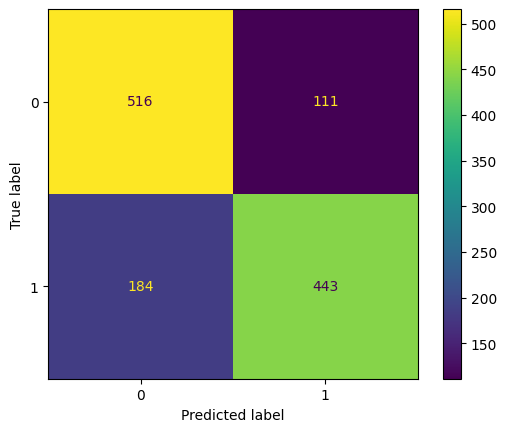

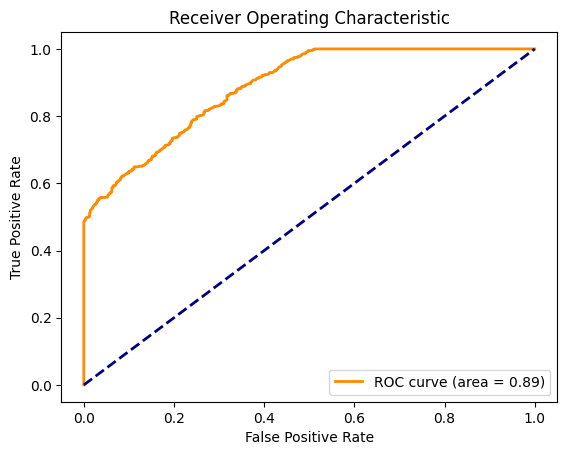

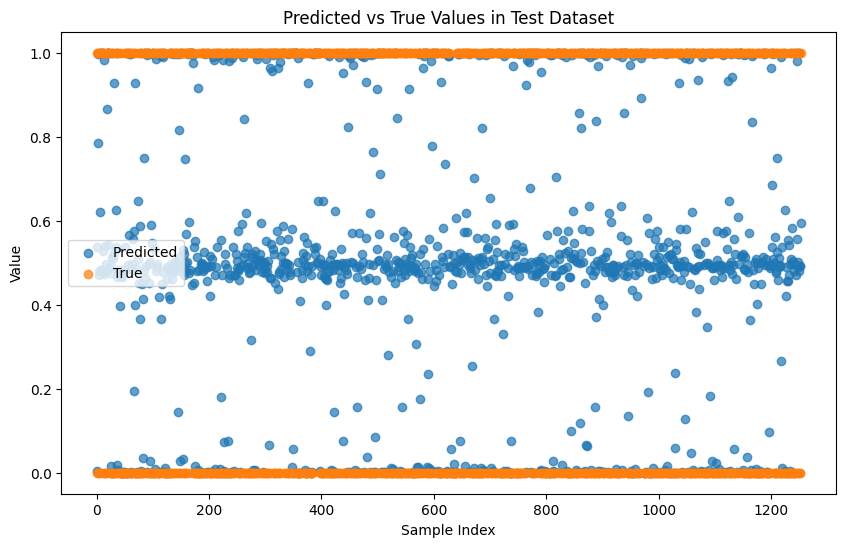

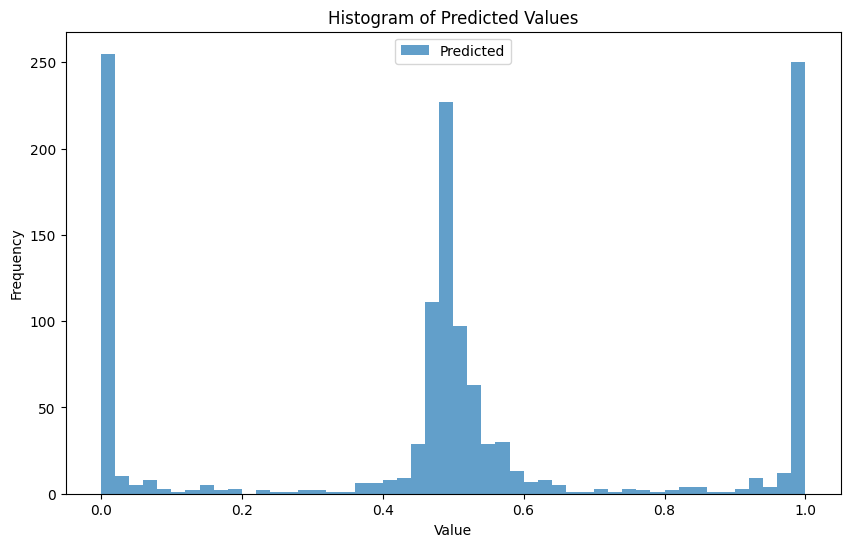

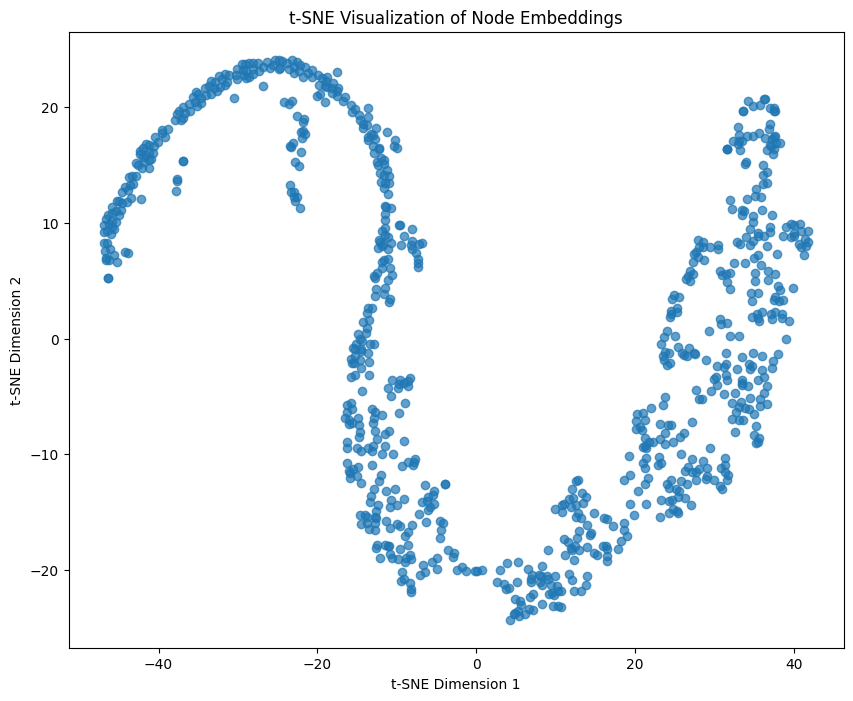

c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\rokaa\egyetem\basketball_lineup_analysis\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


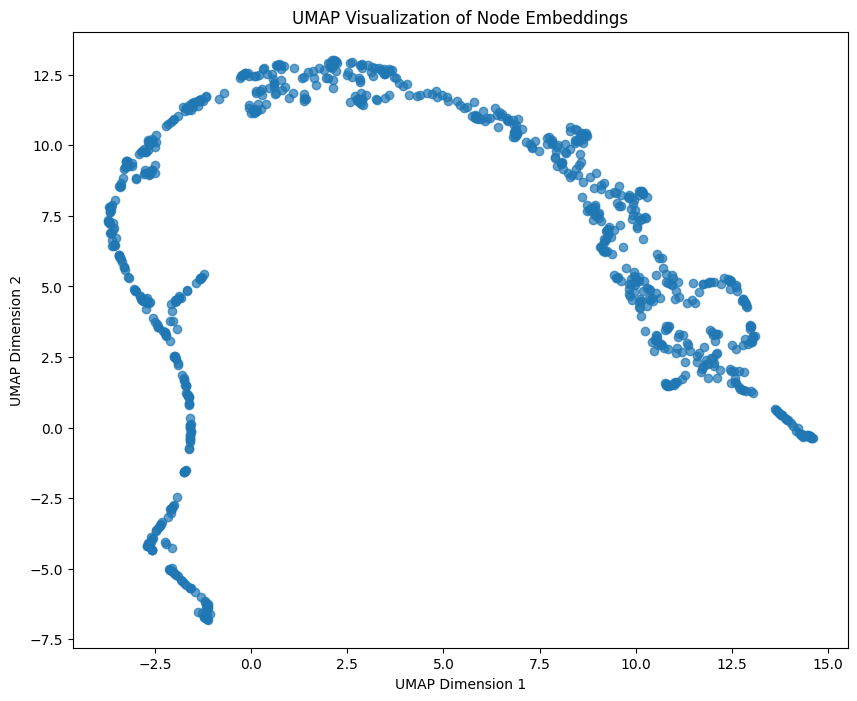

In [11]:
evaluate_model(model, test_data, random_seed=42)

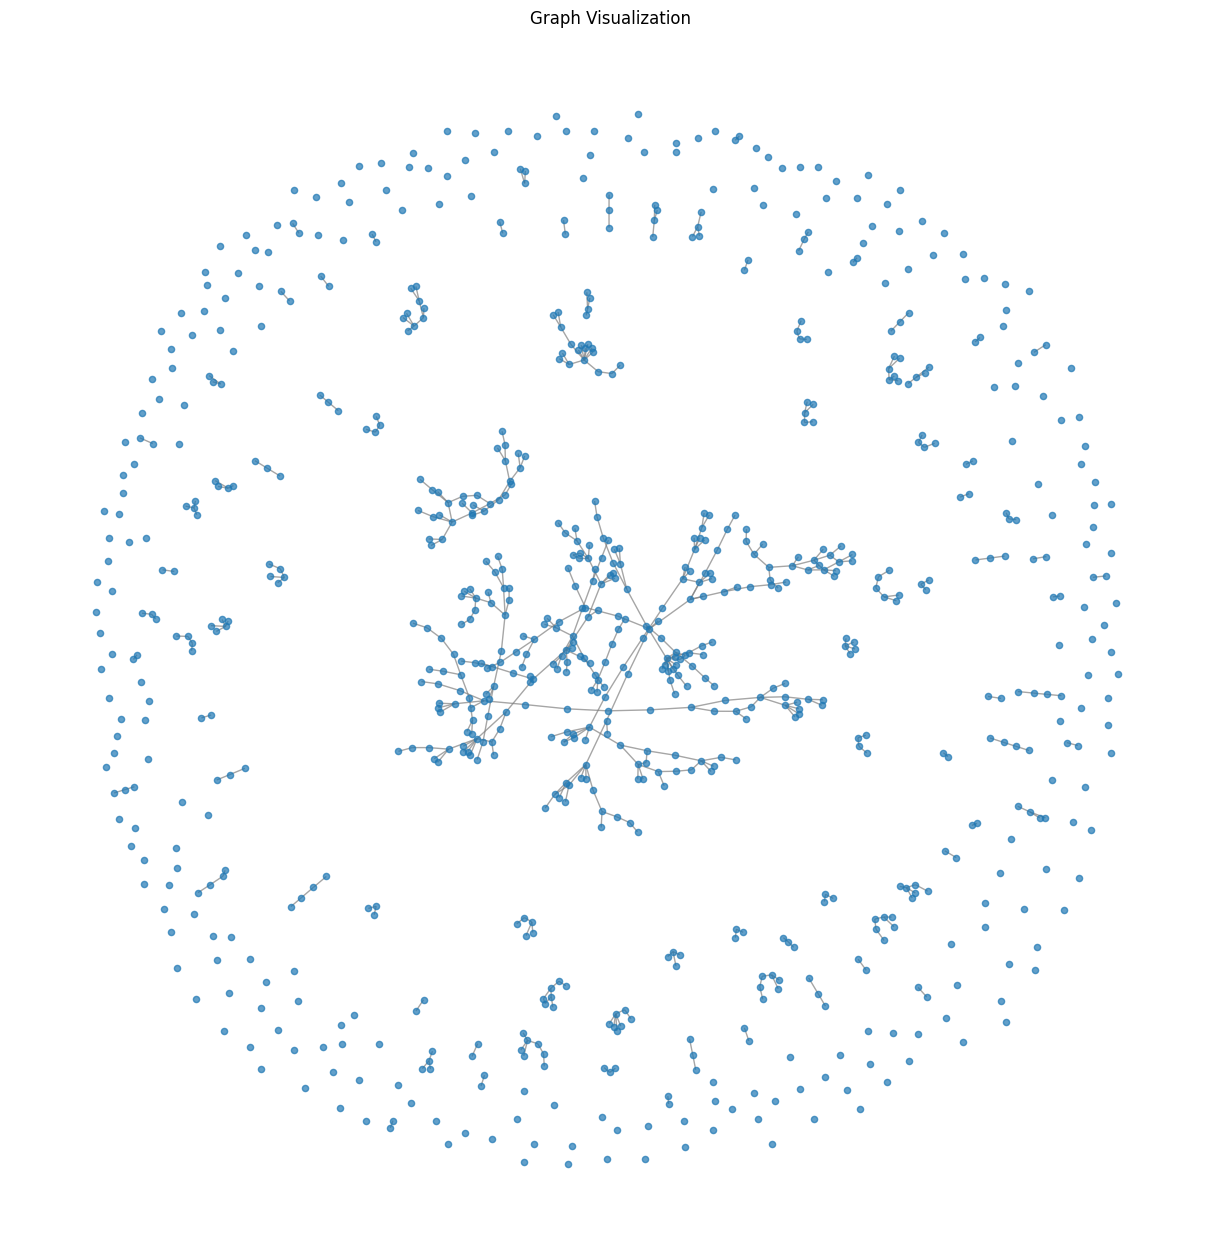

In [13]:
visualize_whole_graph(data=data)